In [60]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

os.chdir("../../..")
import copy
from pathlib import Path
import warnings
import numpy as np
import glob
import pandas as pd
import torch
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.tuner import Tuner
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

First we need to format the dataset each individual tank sample into one large dataframe which contains data from different tanks

In [75]:
max_prediction_length = 2*24 #the goal is to make a one-day forecast 48
max_encoder_length = 7*2*24
group = 0# a week 336
folder = 'C:/Users/Administrator/Documents/GitHub/tft/data_simulation/*_Tank.csv'
dfs = []
for i in glob.glob(folder):
    data = pd.read_csv(i, index_col=0).reset_index(drop=True)
    data = data.iloc[:2000]
    data['group_id'] = str(group)
    group += 1
    data["time_idx"] = data.index
    training_cutoff = data["time_idx"].max() - max_prediction_length
    tank_max_height = data["OpeningHeight_readjusted"].max()
    tank_max_volume = data["ClosingHeight_readjusted"].max()
    data['tank_max_height'] = tank_max_height
    data['tank_max_volume'] = tank_max_volume
    data['Month'] = data['Month'].astype(str)
    data['Year'] = data['Year'].astype(str)
    data['period'] = data['period'].astype(str)  
    dfs.append(data) 
combined_df = pd.concat(dfs, ignore_index=True)
combined_df = combined_df.dropna(subset=['ClosingHeight_readjusted'])

In [79]:
combined_df = combined_df.dropna(subset=['ClosingHeight_tc_readjusted'])

In [86]:
training = TimeSeriesDataSet(
    combined_df[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Var_tc_readjusted", #variance
    group_ids=["group_id"], #tank id
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["group_id"], #tank id, tank location state
    static_reals=["tank_max_height", "tank_max_volume"], #tank max height, tank max volume, no. of pumps attached to the tank
    time_varying_known_categoricals=["Time_of_day", "Month", "Year", "Season"], #season, month,
    time_varying_known_reals=["time_idx"], #time_idx,
    time_varying_unknown_categoricals=["period"], #period (idle, transaction, delivery)
    time_varying_unknown_reals=[
        "Var_tc_readjusted",
        "Del_tc",
        "Sales_Ini_tc",
        "ClosingHeight_tc_readjusted",
        "ClosingStock_tc_readjusted",
        "TankTemp",
    ], #variance, volume, height, sales(-), delivery(+), temperature,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)

validation = TimeSeriesDataSet.from_dataset(training, combined_df, predict=True, stop_randomization=True)
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 366   
3  | prescalers                         | ModuleDict                      | 208   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.2 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 6.3 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.7 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_cont

Number of parameters in network: 25.4k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

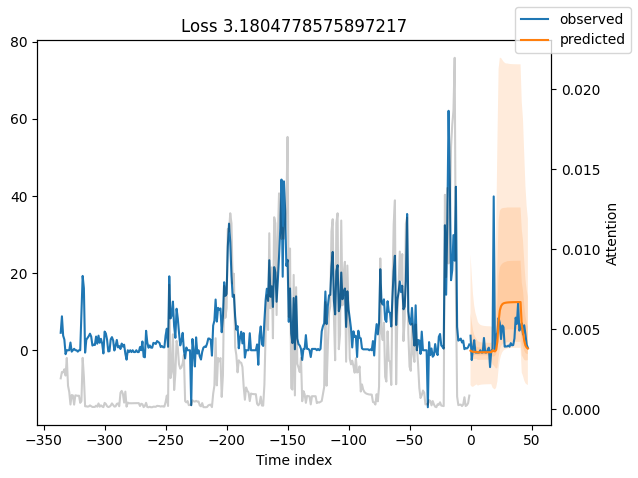

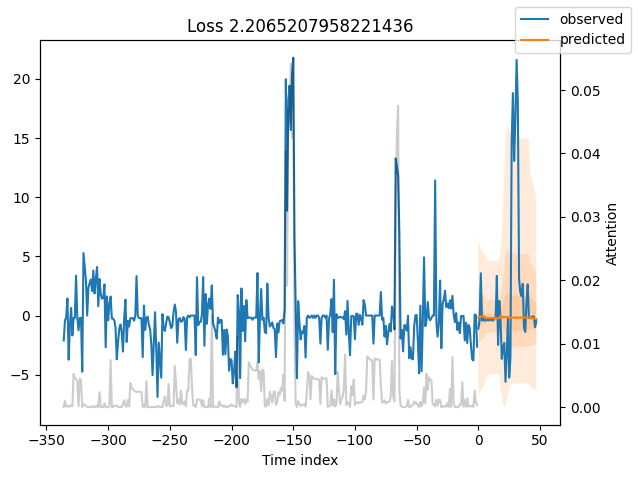

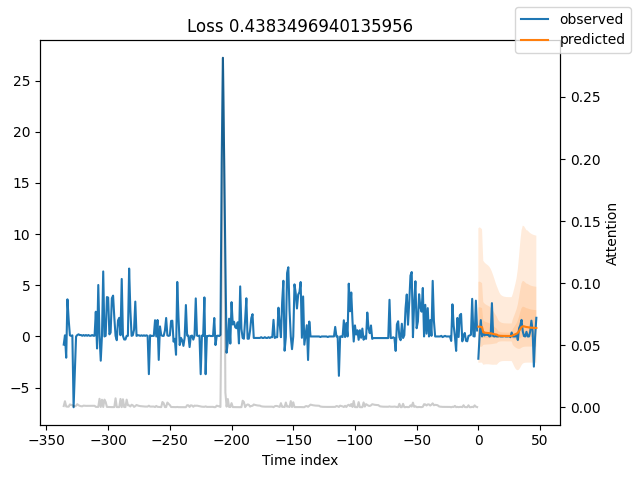

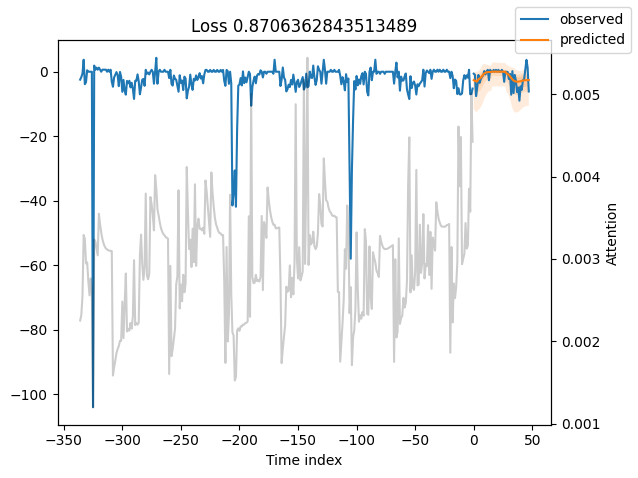

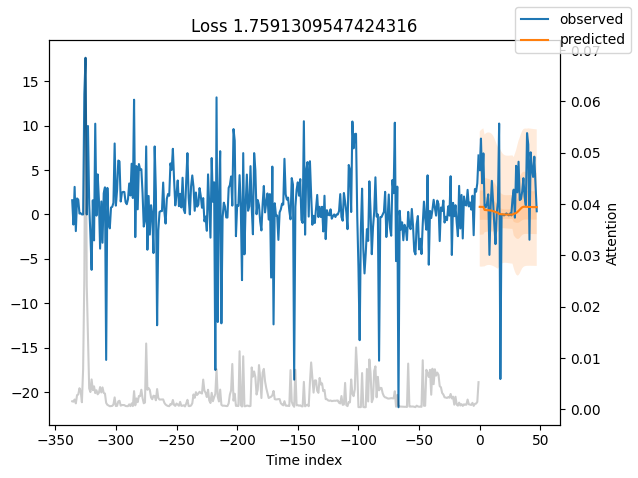

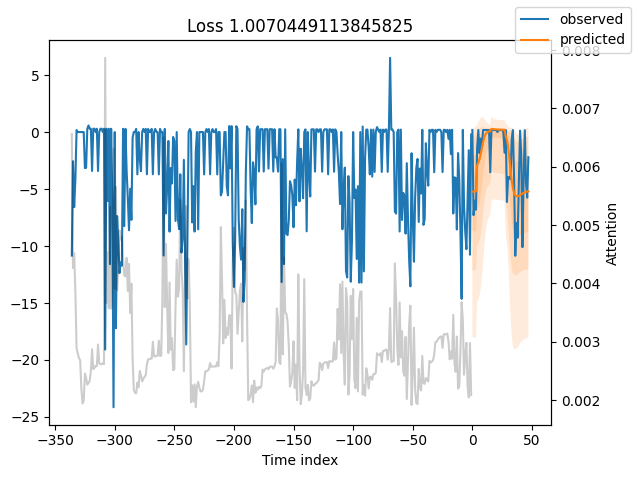

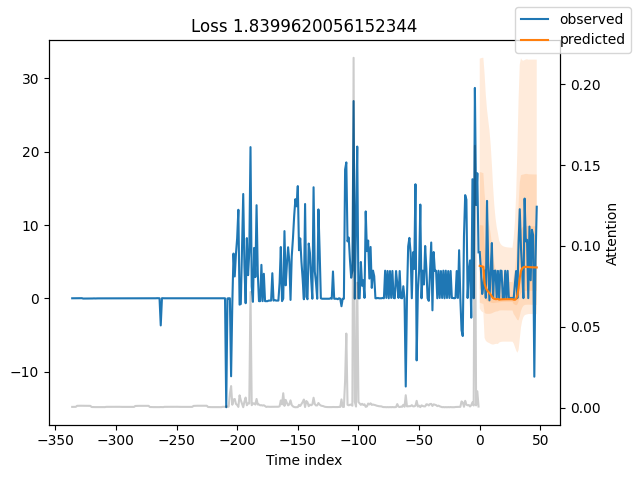

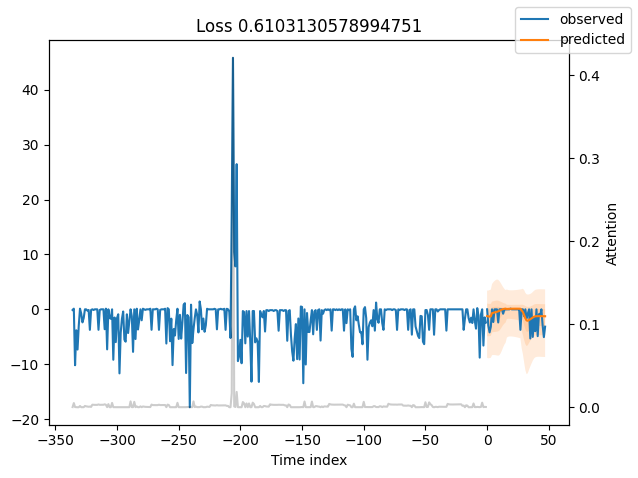

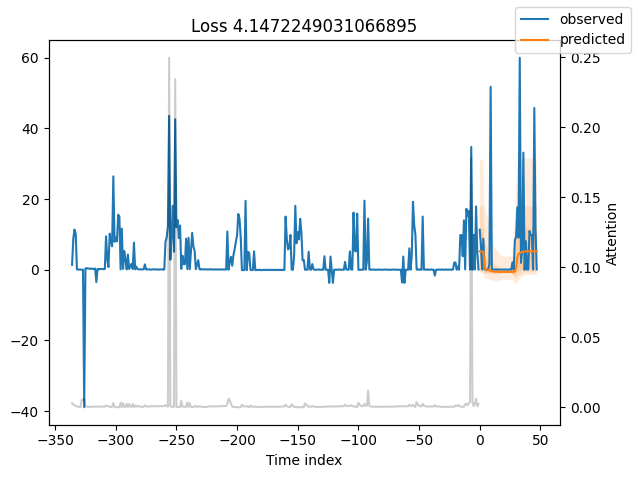

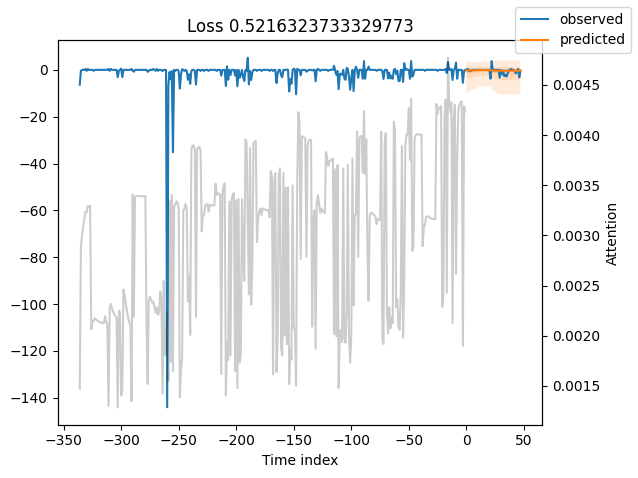

In [87]:
path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(path)
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
MAE()(predictions.output, predictions.y)
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True) # grey line is the attention 

In [14]:
max_prediction_length = 2*24 #the goal is to make a one-day forecast 48
max_encoder_length = 7*2*24 # a week 336
data = pd.read_csv('C:/Users/Administrator/Documents/GitHub/tft/data_simulation/A082_1_0.2_6.csv', index_col=0).reset_index(drop=True)
data = data.iloc[:10000]
data['group_id'] = '0'
data["time_idx"] = data.index
training_cutoff = data["time_idx"].max() - max_prediction_length
tank_max_height = data["OpeningHeight_readjusted"].max()
tank_max_volume = data["ClosingHeight_readjusted"].max()
data['tank_max_height'] = tank_max_height
data['tank_max_volume'] = tank_max_volume
data['Month'] = data['Month'].astype(str)
data['Year'] = data['Year'].astype(str)
data['period'] = data['period'].astype(str)

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="Time_DN",
    target="Var_tc_readjusted", #variance
    group_ids=["group_id"], #tank id
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["group_id"], #tank id, tank location state
    static_reals=["tank_max_height", "tank_max_volume"], #tank max height, tank max volume, no. of pumps attached to the tank
    time_varying_known_categoricals=["Time_of_day", "Month", "Year", "Season"], #season, month,
    time_varying_known_reals=["Time_DN"], #time_idx,
    time_varying_unknown_categoricals=["period"], #period (idle, transaction, delivery)
    time_varying_unknown_reals=[
        "Var_tc_readjusted",
        "Del_tc",
        "Sales_Ini_tc",
        "ClosingHeight_tc_readjusted",
        "ClosingStock_tc_readjusted",
        "TankTemp",
    ], #variance, volume, height, sales(-), delivery(+), temperature,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=3,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 73    
3  | prescalers                         | ModuleDict                      | 208   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.1 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 6.3 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.7 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_cont

Number of parameters in network: 25.1k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


In [15]:
path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(path)
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
MAE()(predictions.output, predictions.y)

tensor(2.4503)

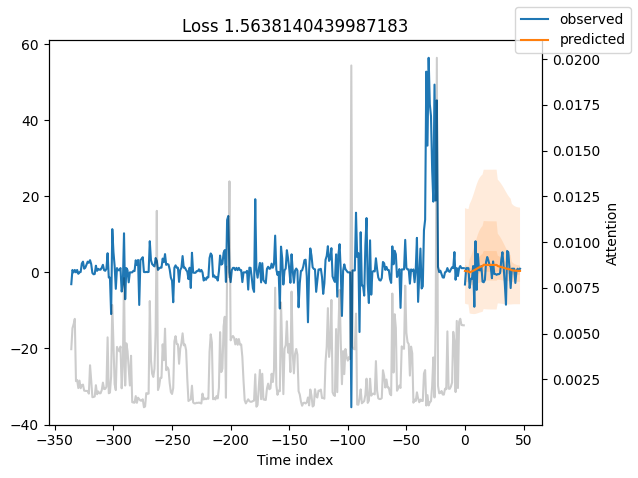

In [17]:
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)
for idx in range(1):  # plot 10 examples
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True) # grey line is the attention 